**Orignal LSTM**

Trial 3 Complete [00h 06m 15s]
val_loss: 0.0004836946027353406

Best val_loss So Far: 0.0004836946027353406
Total elapsed time: 00h 25m 30s
Optimal Learning Rate: 0.0012699408601506144
Optimal Hidden Units 1: 40
Optimal Hidden Units 2: 10
Epoch 1/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 33s 136ms/step - loss: 0.0146 - val_loss: 0.0026
Epoch 2/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 39s 128ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 3/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 41s 128ms/step - loss: 7.2442e-04 - val_loss: 7.9164e-04
Epoch 4/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 41s 129ms/step - loss: 3.8894e-04 - val_loss: 0.0011
Epoch 5/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 42s 133ms/step - loss: 4.5025e-04 - val_loss: 4.6550e-04
Epoch 6/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 41s 133ms/step - loss: 3.4197e-04 - val_loss: 3.9396e-04
Epoch 7/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 41s 133ms/step - loss: 2.9200e-04 - val_loss: 4.0231e-04
Epoch 8/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 28s 129ms/step - loss: 2.6731e-04 - val_loss: 4.2504e-04
Epoch

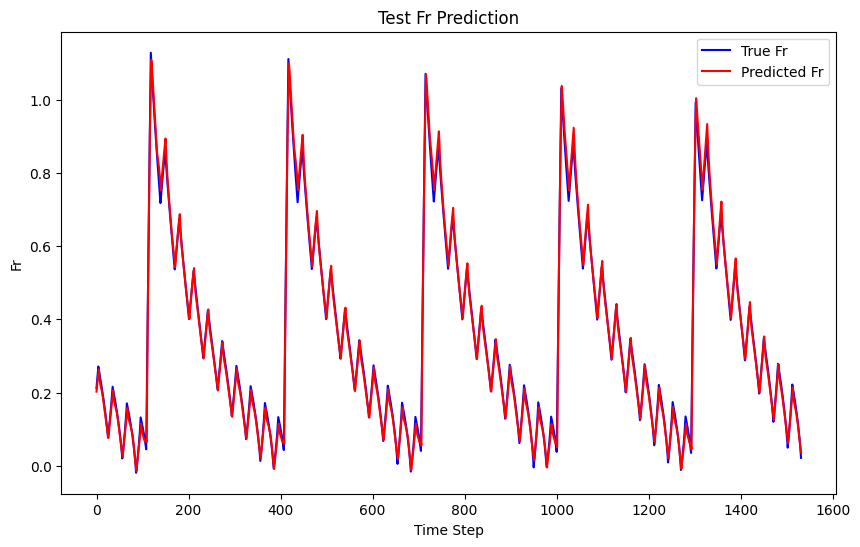

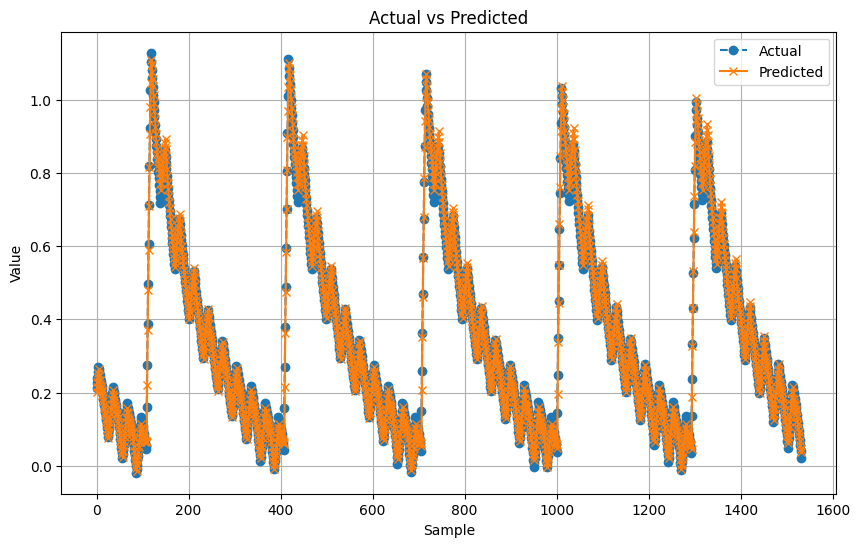

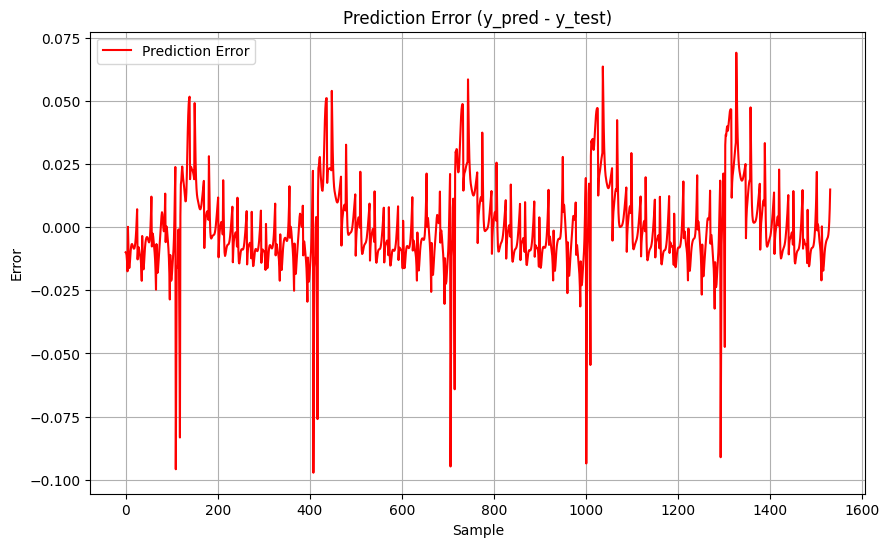

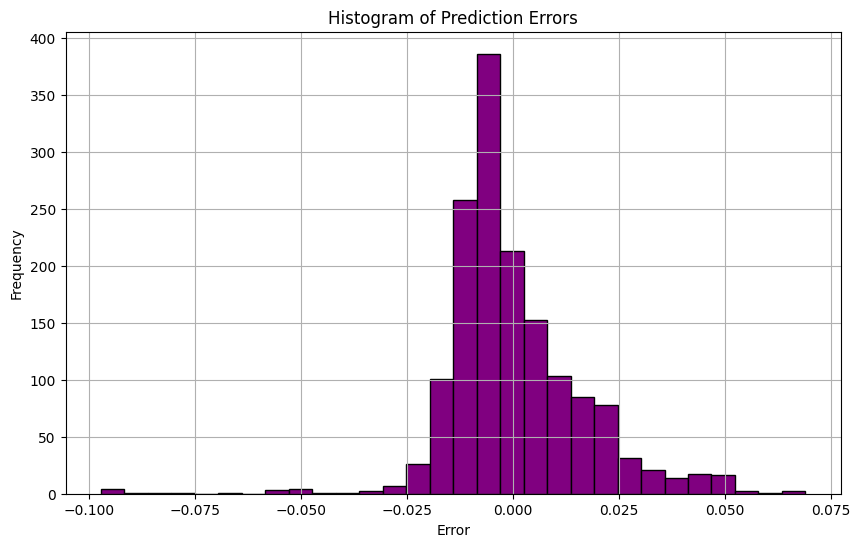

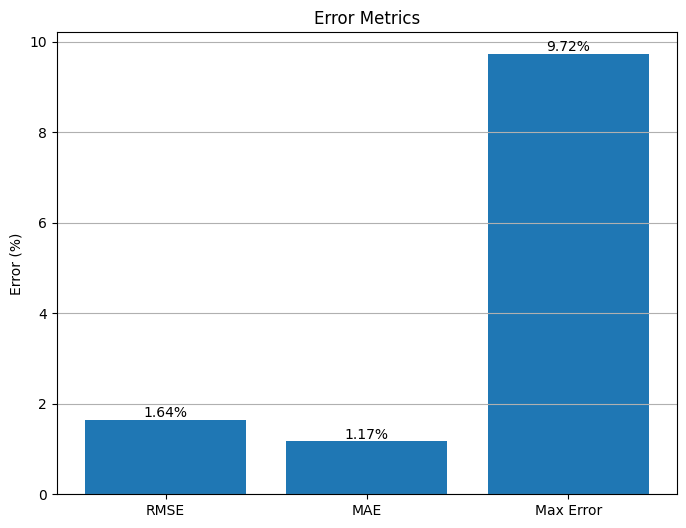

              Metric     Value
0               RMSE  0.016365
1                MAE  0.011669
2      Max Abs Error  0.097209
3  Mean Error (Bias)  0.000111
4  Std Dev of Errors  0.016365
5   Median Abs Error  0.008608
6          R-squared  0.996016
7               MAPE  7.986645


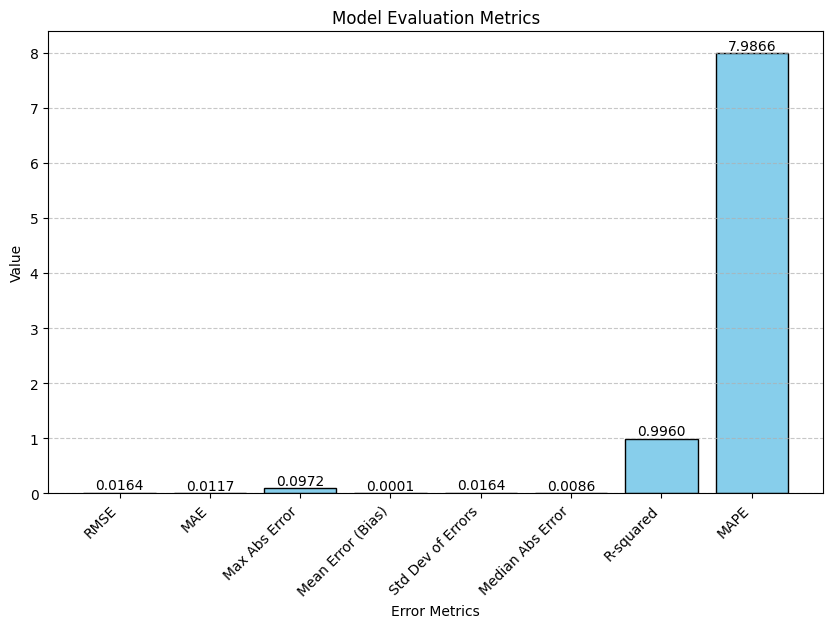

                               Metric    Value
       Root Mean Squared Error (RMSE) 0.016365
            Mean Absolute Error (MAE) 0.011669
                   Max Absolute Error 0.097209
                    Mean Error (Bias) 0.000111
         Standard Deviation of Errors 0.016365
                Median Absolute Error 0.008608
                      R-squared Score 0.996016
Mean Absolute Percentage Error (MAPE) 7.986645


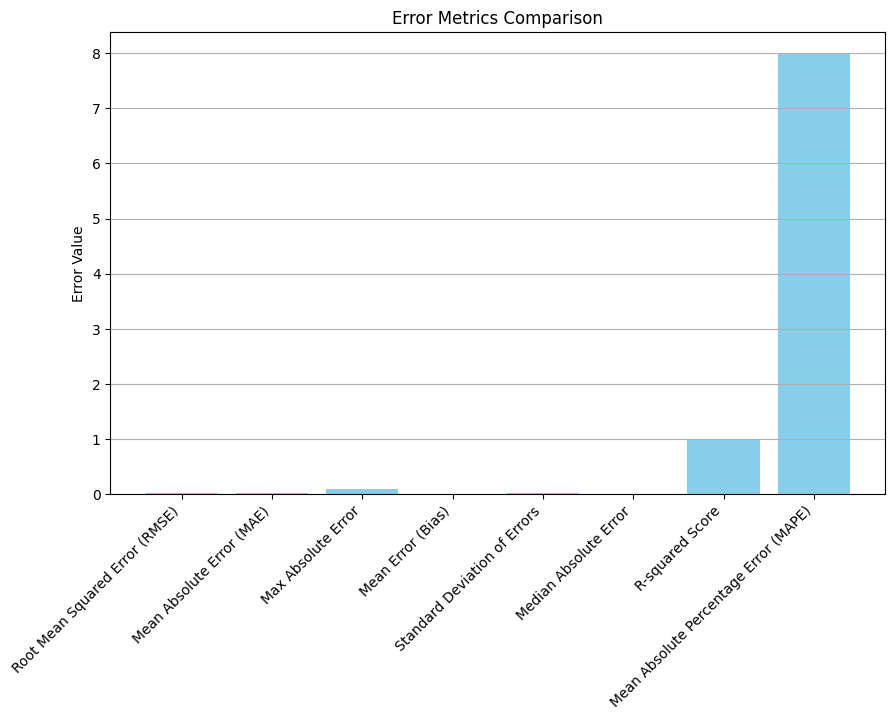

Root Mean Squared Error (RMSE): 2.3238
Mean Absolute Error (MAE): 2.2000
Max Absolute Error: 3.0000
Mean Error (Bias): 0.2000
Standard Deviation of Errors: 2.3152
Median Absolute Error: 2.0000
R-squared Score: 0.9730
Mean Absolute Percentage Error (MAPE): 9.90%


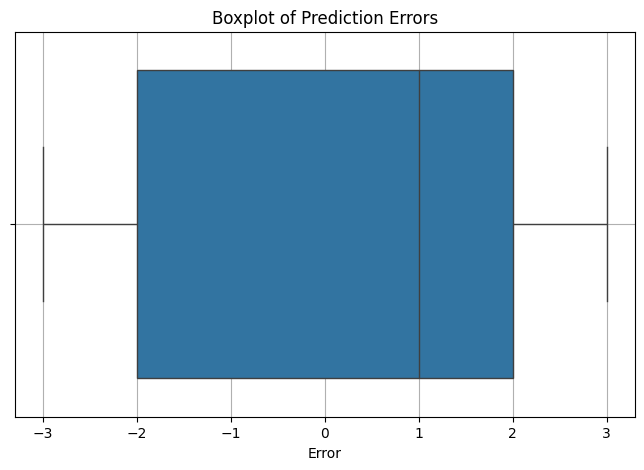

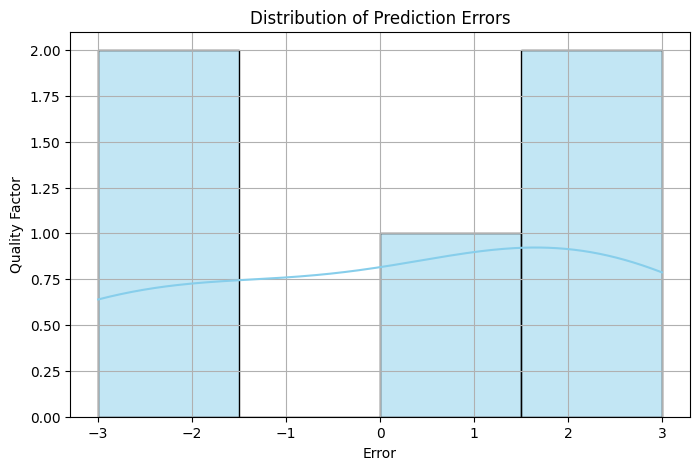

In [ ]:
# Install keras-tuner before importing it
!pip install -q keras-tuner

import numpy as np
import pandas as pd
import scipy.io
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt  # <- corrected import
import matplotlib.pyplot as plt


# 1. Load and Preprocess the Data
train = pd.read_excel('Train.xlsx')
test = pd.read_excel('Test.xlsx')

train.head()

test.isnull().sum()

train.shape, test.shape

# 2. Data Cleaning
train = train.dropna()
test = test.dropna()

train.head()

train = train.rename(columns = {"K":"k"})
test = test.rename(columns = {"K":"k"})
train.head()


features = ['k', 'm', 'b']
target1 = 'Fr'


# Remove outliers using z-score thresholding
z_threshold = 3
z_scores_train = np.abs(zscore(train[features]))
train_data = train[(z_scores_train < z_threshold).all(axis=1)]

z_scores_test = np.abs(zscore(test[features]))
test_data = test[(z_scores_test < z_threshold).all(axis=1)]


# Smooth data using a moving average filter
window_size = 10
train_data[features] = train_data[features].rolling(window=window_size, min_periods=1).mean()
test_data[features] = test_data[features].rolling(window=window_size, min_periods=1).mean()
train_data[target1] = train_data[target1].rolling(window=window_size, min_periods=1).mean()
test_data[target1] = test_data[target1].rolling(window=window_size, min_periods=1).mean()


# 3. Compute Additional Features
window_size_avg = 5
train_data['Avg_k'] = train_data['k'].rolling(window=window_size_avg, min_periods=1).mean()
train_data['Avg_m'] = train_data['m'].rolling(window=window_size_avg, min_periods=1).mean()
train_data['Avg_b'] = train_data['b'].rolling(window=window_size_avg, min_periods=1).mean()

test_data['Avg_k'] = test_data['k'].rolling(window=window_size_avg, min_periods=1).mean()
test_data['Avg_m'] = test_data['m'].rolling(window=window_size_avg, min_periods=1).mean()
test_data['Avg_b'] = test_data['b'].rolling(window=window_size_avg, min_periods=1).mean()


features += ['Avg_k', 'Avg_m', 'Avg_b']

# 4. Normalize/Scale the Data
scaler = MinMaxScaler()

train_data[features] = scaler.fit_transform(train_data[features])
test_data[features] = scaler.transform(test_data[features])
train_data[[target1]] = scaler.fit_transform(train_data[[target1]])
test_data[[target1]] = scaler.transform(test_data[[target1]])

# 5. Create Sequences for LSTM
def create_sequences(data, feature_cols, target_col, seq_len):
    X, Y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[feature_cols].iloc[i:i+seq_len].values)
        Y.append(data[target_col].iloc[i+seq_len])
    return np.array(X), np.array(Y)

seq_length = 200
X_train, y_train = create_sequences(train_data, features, target1, seq_length)
X_test, y_test = create_sequences(test_data, features, target1, seq_length)

# 6. Hyperparameter Optimization via Keras Tuner (Bayesian Optimization)
def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units1', min_value=10, max_value=100, step=10),
                   return_sequences=True, input_shape=(seq_length, len(features))))
    model.add(LSTM(units=hp.Int('units2', min_value=5, max_value=50, step=5)))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', 1e-4, 1e-1, sampling='log')),
                  loss='mse')
    return model


tuner = kt.BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=3,
    directory='kt_dir',
    project_name='lstm_tuning'
)


tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test), verbose=1)
best_hps = tuner.get_best_hyperparameters()[0]

print(f'Optimal Learning Rate: {best_hps.get("learning_rate")}')
print(f'Optimal Hidden Units 1: {best_hps.get("units1")}')
print(f'Optimal Hidden Units 2: {best_hps.get("units2")}')


# 7. Final Training Using Best Hyperparameters
final_model = tuner.hypermodel.build(best_hps)
early_stop = EarlyStopping(monitor='val_loss', patience=5)

history = final_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)


# 8. Evaluate the Model
N = 50
NN = 50

y_pred = final_model.predict(X_test, batch_size=32).flatten()

y_pred_trim = y_pred[N:len(y_pred)-NN]
y_test_trim = y_test[N:len(y_test)-NN]

error_test = y_pred_trim - y_test_trim
rmse = np.sqrt(np.mean(error_test ** 2)) * 100
mae = np.mean(np.abs(error_test)) * 100
max_error = np.max(np.abs(error_test)) * 100

print(f'Test RMSE: {rmse:.4f}%')
print(f'Test MAE: {mae:.4f}%')
print(f'Test MAX: {max_error:.4f}%')

# 9. Plot 1: Predictions in the Time Domain
plt.figure(figsize=(10, 6))
plt.plot(y_test_trim, 'b', linewidth=1.5, label='True Fr')
plt.plot(y_pred_trim, 'r', linewidth=1.5, label='Predicted Fr')
plt.xlabel('Time Step')
plt.ylabel('Fr')
plt.title('Test Fr Prediction')
plt.legend()
plt.show()

# Plot 2: Predicted vs Actual values
plt.figure(figsize=(10, 6))
plt.plot(y_test_trim, label='Actual', marker='o', linestyle='--')
plt.plot(y_pred_trim, label='Predicted', marker='x', linestyle='-')
plt.title('Actual vs Predicted')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# Plot 3: Error over samples
plt.figure(figsize=(10, 6))
plt.plot(error_test, label='Prediction Error', color='red')
plt.title('Prediction Error (y_pred - y_test)')
plt.xlabel('Sample')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.show()

# Plot 4: Histogram of errors
plt.figure(figsize=(10, 6))
plt.hist(error_test, bins=30, color='purple', edgecolor='black')
plt.title('Histogram of Prediction Errors')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plot 5: Bar Chart of Error Metrics
error_metrics = ['RMSE', 'MAE', 'Max Error']
values = [rmse, mae, max_error]

plt.figure(figsize=(8, 6))
bars = plt.bar(error_metrics, values)
plt.title('Error Metrics')
plt.ylabel('Error (%)')

# Annotate each bar with its value
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}%', ha='center', va='bottom')

plt.grid(axis='y')
plt.show()

from sklearn.metrics import mean_absolute_error, max_error, r2_score, median_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Compute additional error metrics
rmse = np.sqrt(mean_squared_error(y_test_trim, y_pred_trim))
mae = mean_absolute_error(y_test_trim, y_pred_trim)
max_abs_error = max_error(y_test_trim, y_pred_trim)
mean_error = np.mean(y_pred_trim - y_test_trim)
std_dev_error = np.std(y_pred_trim - y_test_trim)
median_abs_error = median_absolute_error(y_test_trim, y_pred_trim)
r2 = r2_score(y_test_trim, y_pred_trim)
mape = np.mean(np.abs((y_test_trim - y_pred_trim) / y_test_trim)) * 100

# Create a DataFrame for better visualization
error_df = pd.DataFrame({
    'Metric': ['RMSE', 'MAE', 'Max Abs Error', 'Mean Error (Bias)', 'Std Dev of Errors', 'Median Abs Error', 'R-squared', 'MAPE'],
    'Value': [rmse, mae, max_abs_error, mean_error, std_dev_error, median_abs_error, r2, mape]
})

# Display the table
print(error_df)

# Plot error metrics in a bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(error_df['Metric'], error_df['Value'], color='skyblue', edgecolor='black')
plt.xlabel('Error Metrics')
plt.ylabel('Value')
plt.title('Model Evaluation Metrics')
plt.xticks(rotation=45, ha='right')

# Annotate each bar with its value
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.4f}', ha='center', va='bottom')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Compute error metrics
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

rmse = np.sqrt(mean_squared_error(y_test_trim, y_pred_trim))
mae = mean_absolute_error(y_test_trim, y_pred_trim)
max_error = np.max(np.abs(y_pred_trim - y_test_trim))
mean_error = np.mean(y_pred_trim - y_test_trim)
std_dev_error = np.std(y_pred_trim - y_test_trim)
median_error = median_absolute_error(y_test_trim, y_pred_trim)
r2 = r2_score(y_test_trim, y_pred_trim)
mape = mean_absolute_percentage_error(y_test_trim, y_pred_trim)

# Create DataFrame for error metrics
data = {
    "Metric": ["Root Mean Squared Error (RMSE)", "Mean Absolute Error (MAE)", "Max Absolute Error",
                "Mean Error (Bias)", "Standard Deviation of Errors", "Median Absolute Error",
                "R-squared Score", "Mean Absolute Percentage Error (MAPE)"],
    "Value": [rmse, mae, max_error, mean_error, std_dev_error, median_error, r2, mape]
}

results_df = pd.DataFrame(data)

# Display the table
print(results_df.to_string(index=False))

# Plot a bar chart of error metrics
plt.figure(figsize=(10, 6))
plt.bar(results_df["Metric"], results_df["Value"], color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Error Value")
plt.title("Error Metrics Comparison")
plt.grid(axis='y')
plt.show()

##########


import numpy as np
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_percentage_error

# Example data (replace with your data)
test_Y = np.array([10, 20, 30, 40, 50])      # Actual values
predictions = np.array([12, 18, 33, 37, 49])  # Predicted values

# Compute errors
errors = test_Y - predictions

# Basic Error Metrics
rmse = np.sqrt(np.mean(errors ** 2))
mae = np.mean(np.abs(errors))
max_error = np.max(np.abs(errors))

# Additional Statistical Metrics
mean_error = np.mean(errors)  # Bias
std_error = np.std(errors)    # Standard deviation of errors
median_abs_error = median_absolute_error(test_Y, predictions)  # Robust to outliers
r_squared = r2_score(test_Y, predictions)  # Goodness of fit
mape = mean_absolute_percentage_error(test_Y, predictions) * 100  # In percentage

# Display results
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Max Absolute Error: {max_error:.4f}")
print(f"Mean Error (Bias): {mean_error:.4f}")
print(f"Standard Deviation of Errors: {std_error:.4f}")
print(f"Median Absolute Error: {median_abs_error:.4f}")
print(f"R-squared Score: {r_squared:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

import matplotlib.pyplot as plt
import seaborn as sns

# Boxplot of errors
plt.figure(figsize=(8, 5))
sns.boxplot(x=errors)
plt.title('Boxplot of Prediction Errors')
plt.xlabel('Error')
plt.grid(True)
plt.show()

# Distribution (KDE) plot of errors
plt.figure(figsize=(8, 5))
sns.histplot(errors, kde=True, color='skyblue')
plt.title('Distribution of Prediction Errors')
plt.xlabel('Error')
plt.ylabel('Quality Factor')
plt.grid(True)
plt.show()

**BiLSTM**

Trial 3 Complete [00h 10m 39s]
val_loss: 0.00097664725035429

Best val_loss So Far: 0.00030523352324962616
Total elapsed time: 00h 37m 56s
Optimal Learning Rate: 0.03607423248955111
Optimal Hidden Units 1: 80
Optimal Hidden Units 2: 40
Epoch 1/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 82s 346ms/step - loss: 0.5152 - val_loss: 0.0025
Epoch 2/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 82s 344ms/step - loss: 5.8837e-04 - val_loss: 6.5282e-04
Epoch 3/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 77s 349ms/step - loss: 4.4274e-04 - val_loss: 4.3837e-04
Epoch 4/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 81s 346ms/step - loss: 2.5905e-04 - val_loss: 2.5449e-04
Epoch 5/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 82s 345ms/step - loss: 2.1462e-04 - val_loss: 8.3455e-04
Epoch 6/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 83s 349ms/step - loss: 2.1756e-04 - val_loss: 7.2021e-04
Epoch 7/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 80s 342ms/step - loss: 1.7937e-04 - val_loss: 3.5899e-04
Epoch 8/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 83s 348ms/step - loss: 1.4775e-04 - val_loss: 0.0011


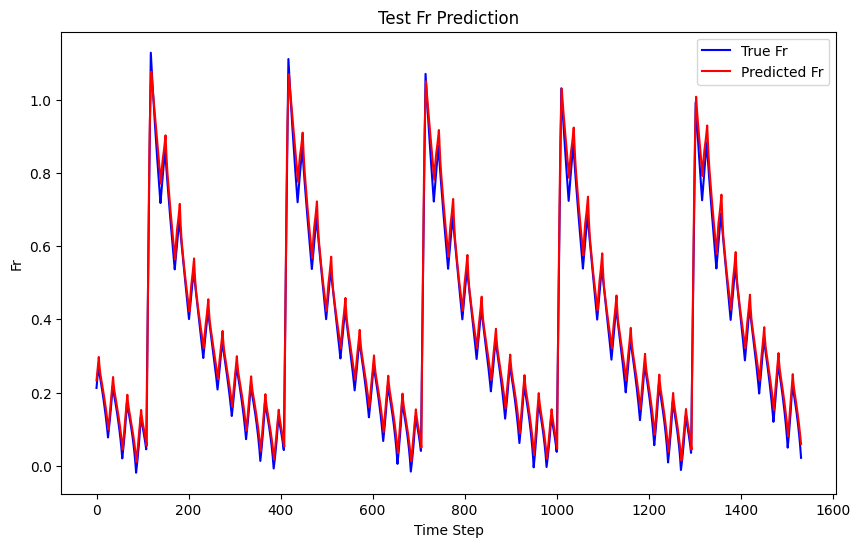

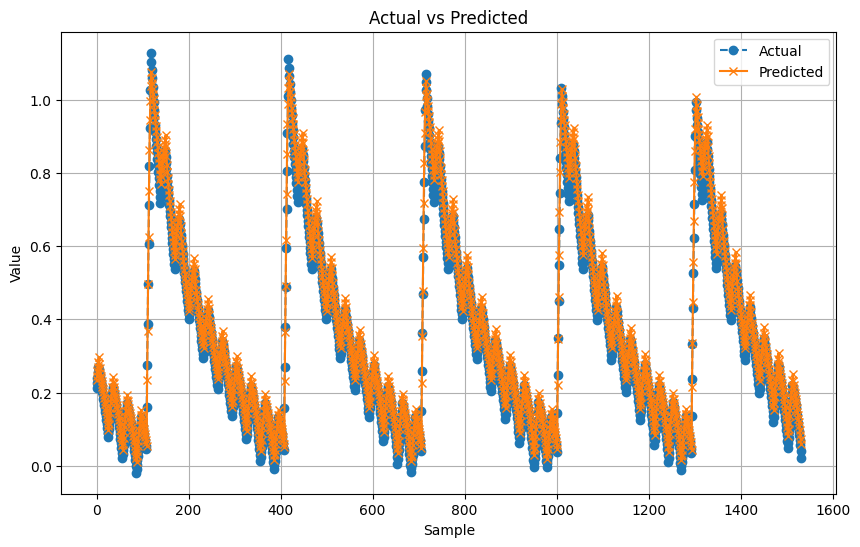

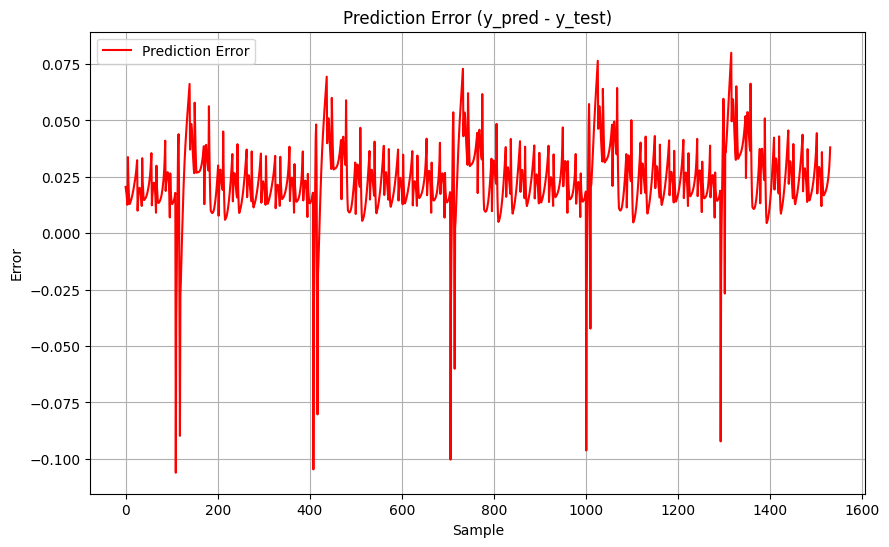

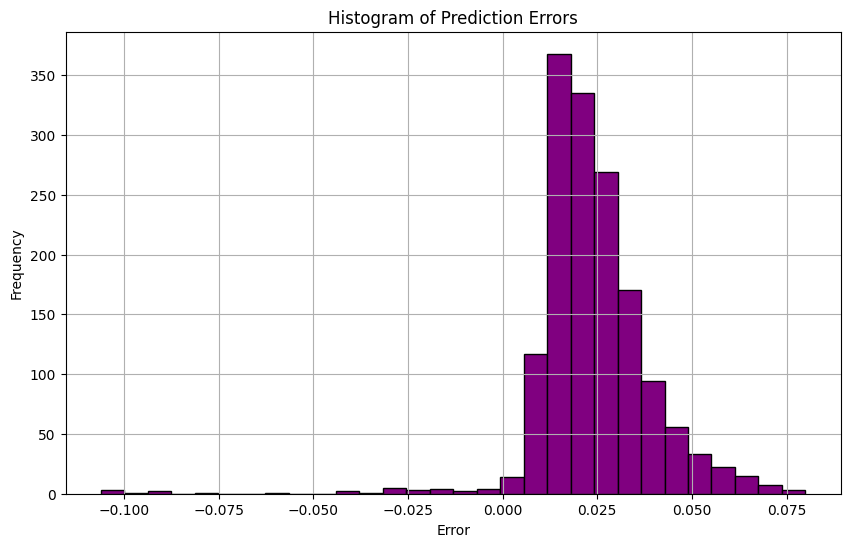

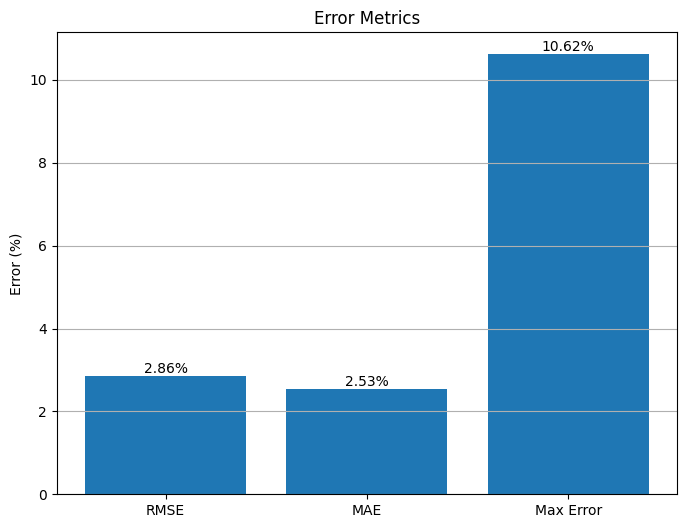

              Metric      Value
0               RMSE   0.028569
1                MAE   0.025310
2      Max Abs Error   0.106175
3  Mean Error (Bias)   0.023799
4  Std Dev of Errors   0.015806
5   Median Abs Error   0.022545
6          R-squared   0.987857
7               MAPE  24.119963


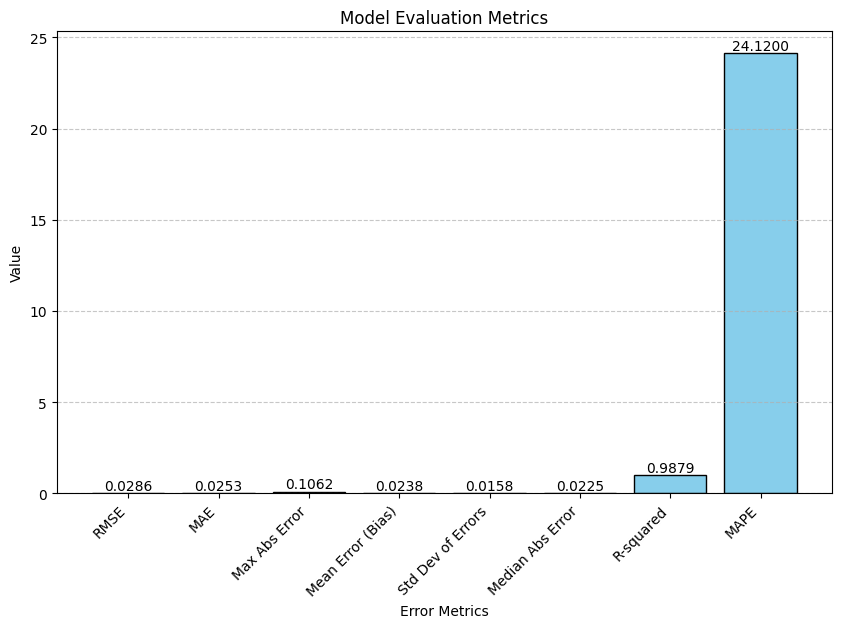

                               Metric     Value
       Root Mean Squared Error (RMSE)  0.028569
            Mean Absolute Error (MAE)  0.025310
                   Max Absolute Error  0.106175
                    Mean Error (Bias)  0.023799
         Standard Deviation of Errors  0.015806
                Median Absolute Error  0.022545
                      R-squared Score  0.987857
Mean Absolute Percentage Error (MAPE) 24.119963


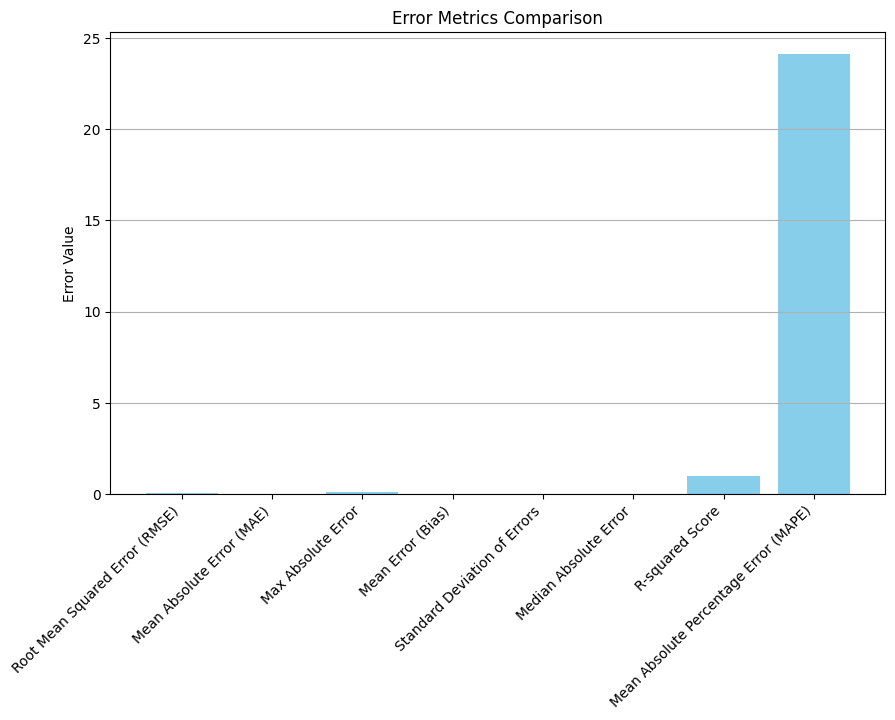

Root Mean Squared Error (RMSE): 2.3238
Mean Absolute Error (MAE): 2.2000
Max Absolute Error: 3.0000
Mean Error (Bias): 0.2000
Standard Deviation of Errors: 2.3152
Median Absolute Error: 2.0000
R-squared Score: 0.9730
Mean Absolute Percentage Error (MAPE): 9.90%


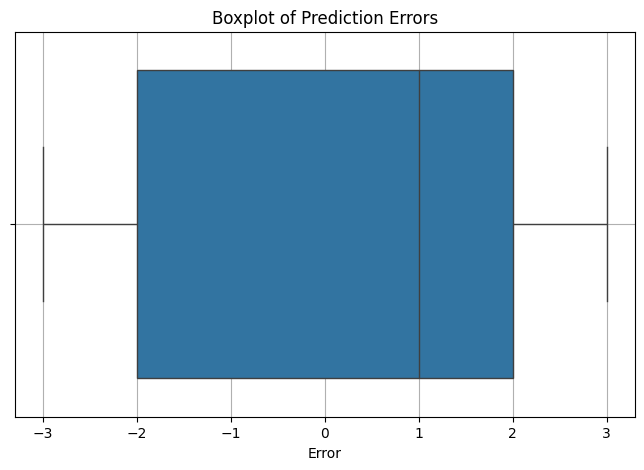

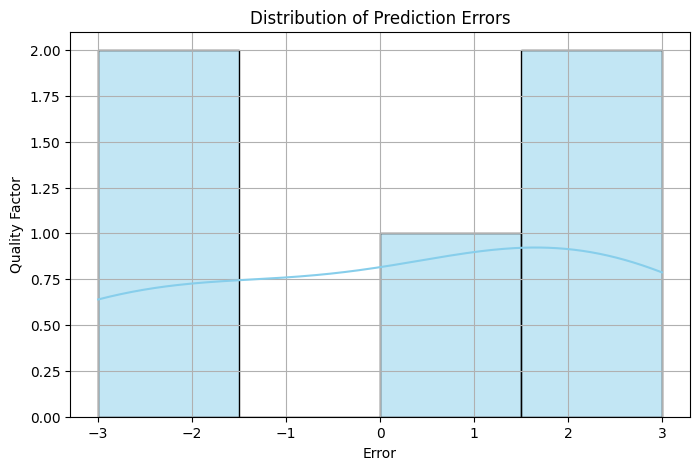

In [ ]:
# Install keras-tuner before importing it
!pip install -q keras-tuner

import numpy as np
import pandas as pd
import scipy.io
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt  # <- corrected import
import matplotlib.pyplot as plt


# 1. Load and Preprocess the Data
train = pd.read_excel('Train.xlsx')
test = pd.read_excel('Test.xlsx')

train.head()

test.isnull().sum()

train.shape, test.shape

# 2. Data Cleaning
train = train.dropna()
test = test.dropna()

train.head()

train = train.rename(columns = {"K":"k"})
test = test.rename(columns = {"K":"k"})
train.head()


features = ['k', 'm', 'b']
target1 = 'Fr'


# Remove outliers using z-score thresholding
z_threshold = 3
z_scores_train = np.abs(zscore(train[features]))
train_data = train[(z_scores_train < z_threshold).all(axis=1)]

z_scores_test = np.abs(zscore(test[features]))
test_data = test[(z_scores_test < z_threshold).all(axis=1)]


# Smooth data using a moving average filter
window_size = 10
train_data[features] = train_data[features].rolling(window=window_size, min_periods=1).mean()
test_data[features] = test_data[features].rolling(window=window_size, min_periods=1).mean()
train_data[target1] = train_data[target1].rolling(window=window_size, min_periods=1).mean()
test_data[target1] = test_data[target1].rolling(window=window_size, min_periods=1).mean()


# 3. Compute Additional Features
window_size_avg = 5
train_data['Avg_k'] = train_data['k'].rolling(window=window_size_avg, min_periods=1).mean()
train_data['Avg_m'] = train_data['m'].rolling(window=window_size_avg, min_periods=1).mean()
train_data['Avg_b'] = train_data['b'].rolling(window=window_size_avg, min_periods=1).mean()

test_data['Avg_k'] = test_data['k'].rolling(window=window_size_avg, min_periods=1).mean()
test_data['Avg_m'] = test_data['m'].rolling(window=window_size_avg, min_periods=1).mean()
test_data['Avg_b'] = test_data['b'].rolling(window=window_size_avg, min_periods=1).mean()


features += ['Avg_k', 'Avg_m', 'Avg_b']

# 4. Normalize/Scale the Data
scaler = MinMaxScaler()

train_data[features] = scaler.fit_transform(train_data[features])
test_data[features] = scaler.transform(test_data[features])
train_data[[target1]] = scaler.fit_transform(train_data[[target1]])
test_data[[target1]] = scaler.transform(test_data[[target1]])

# 5. Create Sequences for BiLSTM
def create_sequences(data, feature_cols, target_col, seq_len):
    X, Y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[feature_cols].iloc[i:i+seq_len].values)
        Y.append(data[target_col].iloc[i+seq_len])
    return np.array(X), np.array(Y)

seq_length = 200
X_train, y_train = create_sequences(train_data, features, target1, seq_length)
X_test, y_test = create_sequences(test_data, features, target1, seq_length)

# 6. Hyperparameter Optimization via Keras Tuner (Bayesian Optimization)
def build_model(hp):
    model = Sequential()
    model.add(Bidirectional(LSTM(units=hp.Int('units1', min_value=10, max_value=100, step=10),
                                 return_sequences=True),
                            input_shape=(seq_length, len(features))))
    model.add(Bidirectional(LSTM(units=hp.Int('units2', min_value=5, max_value=50, step=5))))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', 1e-4, 1e-1, sampling='log')),
                  loss='mse')
    return model


tuner = kt.BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=3,
    directory='kt_dir',
    project_name='bilstm_tuning'
)


tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test), verbose=1)
best_hps = tuner.get_best_hyperparameters()[0]

print(f'Optimal Learning Rate: {best_hps.get("learning_rate")}')
print(f'Optimal Hidden Units 1: {best_hps.get("units1")}')
print(f'Optimal Hidden Units 2: {best_hps.get("units2")}')


# 7. Final Training Using Best Hyperparameters
final_model = tuner.hypermodel.build(best_hps)
early_stop = EarlyStopping(monitor='val_loss', patience=5)

history = final_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)


# 8. Evaluate the Model
N = 50
NN = 50

y_pred = final_model.predict(X_test, batch_size=32).flatten()

y_pred_trim = y_pred[N:len(y_pred)-NN]
y_test_trim = y_test[N:len(y_test)-NN]

error_test = y_pred_trim - y_test_trim
rmse = np.sqrt(np.mean(error_test ** 2)) * 100
mae = np.mean(np.abs(error_test)) * 100
max_error = np.max(np.abs(error_test)) * 100

print(f'Test RMSE: {rmse:.4f}%')
print(f'Test MAE: {mae:.4f}%')
print(f'Test MAX: {max_error:.4f}%')

# 9. Plot 1: Predictions in the Time Domain
plt.figure(figsize=(10, 6))
plt.plot(y_test_trim, 'b', linewidth=1.5, label='True Fr')
plt.plot(y_pred_trim, 'r', linewidth=1.5, label='Predicted Fr')
plt.xlabel('Time Step')
plt.ylabel('Fr')
plt.title('Test Fr Prediction')
plt.legend()
plt.show()

# Plot 2: Predicted vs Actual values
plt.figure(figsize=(10, 6))
plt.plot(y_test_trim, label='Actual', marker='o', linestyle='--')
plt.plot(y_pred_trim, label='Predicted', marker='x', linestyle='-')
plt.title('Actual vs Predicted')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# Plot 3: Error over samples
plt.figure(figsize=(10, 6))
plt.plot(error_test, label='Prediction Error', color='red')
plt.title('Prediction Error (y_pred - y_test)')
plt.xlabel('Sample')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.show()

# Plot 4: Histogram of errors
plt.figure(figsize=(10, 6))
plt.hist(error_test, bins=30, color='purple', edgecolor='black')
plt.title('Histogram of Prediction Errors')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plot 5: Bar Chart of Error Metrics
error_metrics = ['RMSE', 'MAE', 'Max Error']
values = [rmse, mae, max_error]

plt.figure(figsize=(8, 6))
bars = plt.bar(error_metrics, values)
plt.title('Error Metrics')
plt.ylabel('Error (%)')

# Annotate each bar with its value
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}%', ha='center', va='bottom')

plt.grid(axis='y')
plt.show()

from sklearn.metrics import mean_absolute_error, max_error, r2_score, median_absolute_error, mean_squared_error

# Compute additional error metrics
rmse = np.sqrt(mean_squared_error(y_test_trim, y_pred_trim))
mae = mean_absolute_error(y_test_trim, y_pred_trim)
max_abs_error = max_error(y_test_trim, y_pred_trim)
mean_error = np.mean(y_pred_trim - y_test_trim)
std_dev_error = np.std(y_pred_trim - y_test_trim)
median_abs_error = median_absolute_error(y_test_trim, y_pred_trim)
r2 = r2_score(y_test_trim, y_pred_trim)
mape = np.mean(np.abs((y_test_trim - y_pred_trim) / y_test_trim)) * 100

# Create a DataFrame for better visualization
error_df = pd.DataFrame({
    'Metric': ['RMSE', 'MAE', 'Max Abs Error', 'Mean Error (Bias)', 'Std Dev of Errors', 'Median Abs Error', 'R-squared', 'MAPE'],
    'Value': [rmse, mae, max_abs_error, mean_error, std_dev_error, median_abs_error, r2, mape]
})

# Display the table
print(error_df)

# Plot error metrics in a bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(error_df['Metric'], error_df['Value'], color='skyblue', edgecolor='black')
plt.xlabel('Error Metrics')
plt.ylabel('Value')
plt.title('Model Evaluation Metrics')
plt.xticks(rotation=45, ha='right')

# Annotate each bar with its value
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.4f}', ha='center', va='bottom')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Compute error metrics
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

rmse = np.sqrt(mean_squared_error(y_test_trim, y_pred_trim))
mae = mean_absolute_error(y_test_trim, y_pred_trim)
max_error = np.max(np.abs(y_pred_trim - y_test_trim))
mean_error = np.mean(y_pred_trim - y_test_trim)
std_dev_error = np.std(y_pred_trim - y_test_trim)
median_error = median_absolute_error(y_test_trim, y_pred_trim)
r2 = r2_score(y_test_trim, y_pred_trim)
mape = mean_absolute_percentage_error(y_test_trim, y_pred_trim)

# Create DataFrame for error metrics
data = {
    "Metric": ["Root Mean Squared Error (RMSE)", "Mean Absolute Error (MAE)", "Max Absolute Error",
                "Mean Error (Bias)", "Standard Deviation of Errors", "Median Absolute Error",
                "R-squared Score", "Mean Absolute Percentage Error (MAPE)"],
    "Value": [rmse, mae, max_error, mean_error, std_dev_error, median_error, r2, mape]
}

results_df = pd.DataFrame(data)

# Display the table
print(results_df.to_string(index=False))

# Plot a bar chart of error metrics
plt.figure(figsize=(10, 6))
plt.bar(results_df["Metric"], results_df["Value"], color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Error Value")
plt.title("Error Metrics Comparison")
plt.grid(axis='y')
plt.show()


##########


import numpy as np
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_percentage_error

# Example data (replace with your data)
test_Y = np.array([10, 20, 30, 40, 50])      # Actual values
predictions = np.array([12, 18, 33, 37, 49])  # Predicted values

# Compute errors
errors = test_Y - predictions

# Basic Error Metrics
rmse = np.sqrt(np.mean(errors ** 2))
mae = np.mean(np.abs(errors))
max_error = np.max(np.abs(errors))

# Additional Statistical Metrics
mean_error = np.mean(errors)  # Bias
std_error = np.std(errors)    # Standard deviation of errors
median_abs_error = median_absolute_error(test_Y, predictions)  # Robust to outliers
r_squared = r2_score(test_Y, predictions)  # Goodness of fit
mape = mean_absolute_percentage_error(test_Y, predictions) * 100  # In percentage

# Display results
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Max Absolute Error: {max_error:.4f}")
print(f"Mean Error (Bias): {mean_error:.4f}")
print(f"Standard Deviation of Errors: {std_error:.4f}")
print(f"Median Absolute Error: {median_abs_error:.4f}")
print(f"R-squared Score: {r_squared:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

import seaborn as sns

# Boxplot of errors
plt.figure(figsize=(8, 5))
sns.boxplot(x=errors)
plt.title('Boxplot of Prediction Errors')
plt.xlabel('Error')
plt.grid(True)
plt.show()

# Distribution (KDE) plot of errors
plt.figure(figsize=(8, 5))
sns.histplot(errors, kde=True, color='skyblue')
plt.title('Distribution of Prediction Errors')
plt.xlabel('Error')
plt.ylabel('Quality Factor')
plt.grid(True)
plt.show()
